In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy import signal
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.stats import stats
import os
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import GroupKFold
import pickle
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.api import ExponentialSmoothing
import itertools
from prophet import Prophet

In [127]:
os.chdir('C:\\Users\\polet\\Desktop\\FER\\Duboko ucenje\\Detekcija-anomalija\\input')
#os.chdir('/home/ninio/PycharmProjects/Detekcija-anomalija/input')
for dirname, _, filenames in os.walk('.'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

.\mi_scores_dict.pkl
.\mi_scores_sorted.pkl
.\sample_submission.csv
.\temp_X_test.pkl
.\temp_X_train.pkl
.\test.csv
.\train.csv


In [128]:
temp_X_train = pd.read_pickle('temp_X_train.pkl')
temp_X_test = pd.read_pickle('temp_X_test.pkl')

with open('mi_scores_sorted.pkl', 'rb') as f:
    mi_scores_sorted1 = pickle.load(f)

with open('mi_scores_dict.pkl', 'rb') as f:
    mi_scores_dict1 = pickle.load(f)

In [129]:
temp_X_train.head()

,day,broken,total,label,machine_name,daily_broken_rate,broken_rate,broken_variance,daily_broken_rate_variance,broken_mean,...,broken_kurtosis,daily_broken_rate_kurtosis,daily_broken_rate_expanding_mean,broken_rate_expanding_mean,broken_mean_15,daily_broken_rate_mean_15,broken_std_15,daily_broken_rate_skew_15,broken_kurtosis_15,daily_broken_rate_kurtosis_15
0,0,0,1273,0,AI100196,0.00,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2,1218,0,AI100196,2.00,0.001642,0.0,0.0,0.0,...,0.000000,0.0,2.0000,0.000821,0.0,0.0,0.0,0.0,0.0,0.0
2,2,2,717,0,AI100196,1.00,0.002789,0.0,0.0,0.0,...,0.000000,0.0,1.5000,0.001477,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0,399,0,AI100196,0.00,0.000000,0.0,0.0,0.0,...,0.000000,0.0,1.0000,0.001108,0.0,0.0,0.0,0.0,0.0,0.0
4,4,3,436,0,AI100196,0.75,0.006881,1.8,0.0,1.4,...,-1.601852,0.0,0.9375,0.002262,0.0,0.0,0.0,0.0,0.0,0.0


1. Data preparation
    Find a machine that has seasonality in the feature total. Plot signals from the selected machine using the function from the first exercise.



In [130]:
#Preparing the data so we have easier time to find the seasonality
df_train = temp_X_train.copy()
df_test = temp_X_test.copy()

df_train['timedelta'] = pd.to_timedelta(df_train['day'], unit='D')
initial_timestamp = pd.Timestamp('2018-06-15 00:00:00')
df_train['timestamp'] = initial_timestamp + df_train['timedelta']
df_train.head()

,day,broken,total,label,machine_name,daily_broken_rate,broken_rate,broken_variance,daily_broken_rate_variance,broken_mean,...,daily_broken_rate_expanding_mean,broken_rate_expanding_mean,broken_mean_15,daily_broken_rate_mean_15,broken_std_15,daily_broken_rate_skew_15,broken_kurtosis_15,daily_broken_rate_kurtosis_15,timedelta,timestamp
0,0,0,1273,0,AI100196,0.00,0.000000,0.0,0.0,0.0,...,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0 days,2018-06-15
1,1,2,1218,0,AI100196,2.00,0.001642,0.0,0.0,0.0,...,2.0000,0.000821,0.0,0.0,0.0,0.0,0.0,0.0,1 days,2018-06-16
2,2,2,717,0,AI100196,1.00,0.002789,0.0,0.0,0.0,...,1.5000,0.001477,0.0,0.0,0.0,0.0,0.0,0.0,2 days,2018-06-17
3,3,0,399,0,AI100196,0.00,0.000000,0.0,0.0,0.0,...,1.0000,0.001108,0.0,0.0,0.0,0.0,0.0,0.0,3 days,2018-06-18
4,4,3,436,0,AI100196,0.75,0.006881,1.8,0.0,1.4,...,0.9375,0.002262,0.0,0.0,0.0,0.0,0.0,0.0,4 days,2018-06-19


In [131]:
#Function from first exercise
def plot_machine_signals(df,machine_name):
    machine_data = df[df['machine_name'] == machine_name]
    signal_names = ['broken', 'total','label']
    fig, axs = plt.subplots(len(signal_names), 1, figsize=(15, 5*len(signal_names)))

    for i, signal_name in enumerate(signal_names):
        axs[i].plot(machine_data['day'], machine_data[signal_name])
        axs[i].set_ylabel(signal_name)

        if machine_data['label'].max() == 1:
            min_day = machine_data[machine_data['label'] == 1]['day'].min()
            max_day = machine_data[machine_data['label'] == 1]['day'].max()
            axs[i].axvspan(xmin = min_day , xmax = max_day, color='red',alpha=0.8)
    fig.suptitle(f'Signals for Machine {machine_name}')
    plt.show()

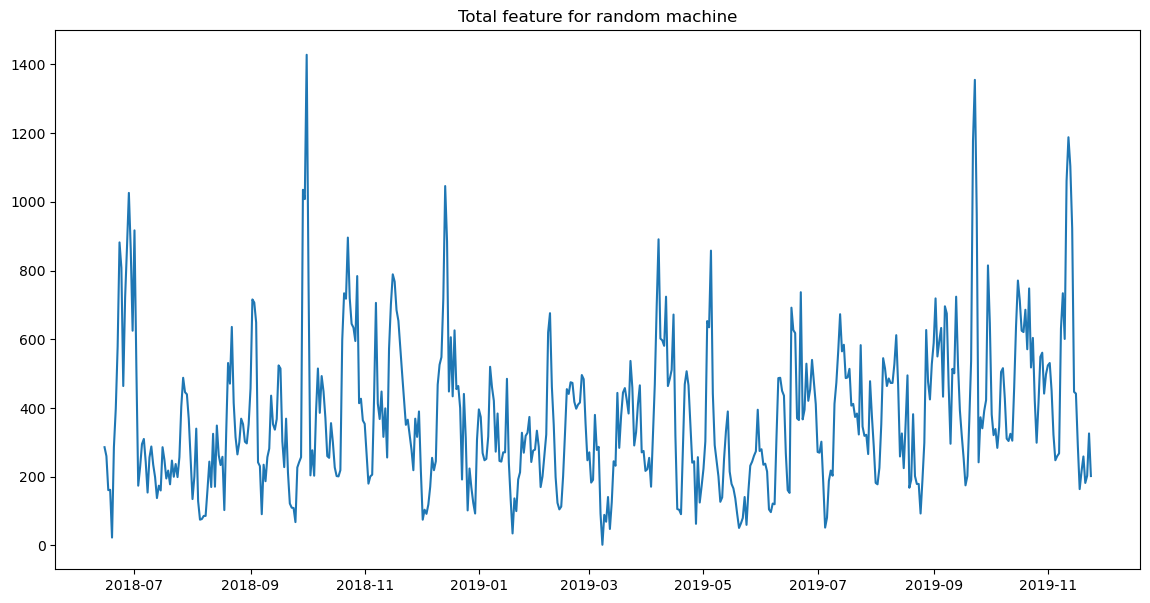

In [132]:
#We are using the autocorrelation to find seasonality machine
#For example we can select random machine
selected_machine = df_train[df_train['machine_name'] == 'CS103864']

#Lets graph the total feature
plt.figure(figsize=(14, 7))
plt.plot(selected_machine['timestamp'], selected_machine['total'])
plt.title('Total feature for random machine')
plt.show()

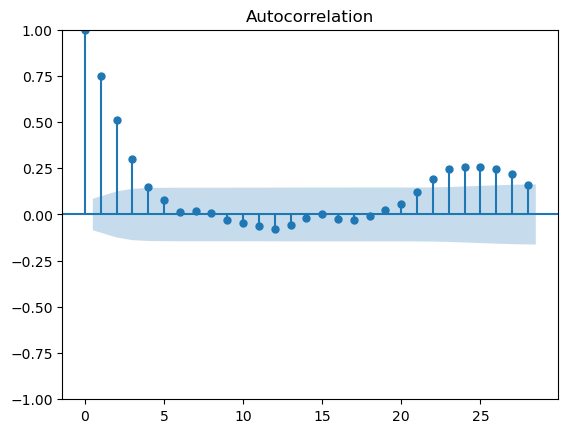

In [133]:
#Lets show its autocorrelation
plot_acf(selected_machine['total'].dropna())
plt.show()

In the ACF plot, if you see regularly spaced significant spikes, this indicates seasonality.
In this case, the spikes are not regularly spaced, so there is no seasonality in the signal.

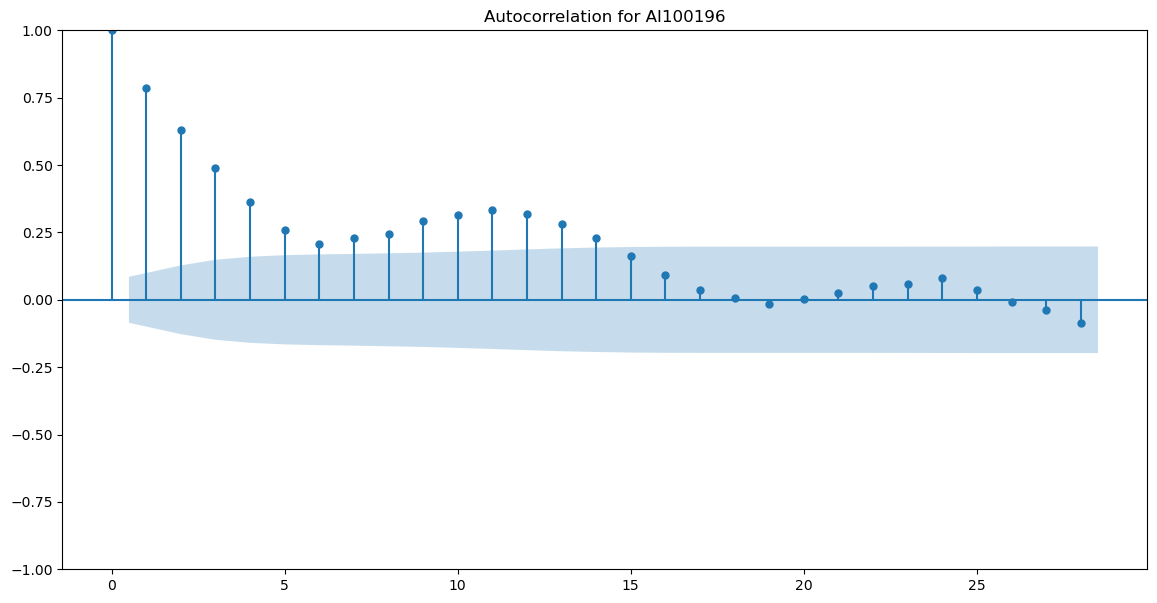

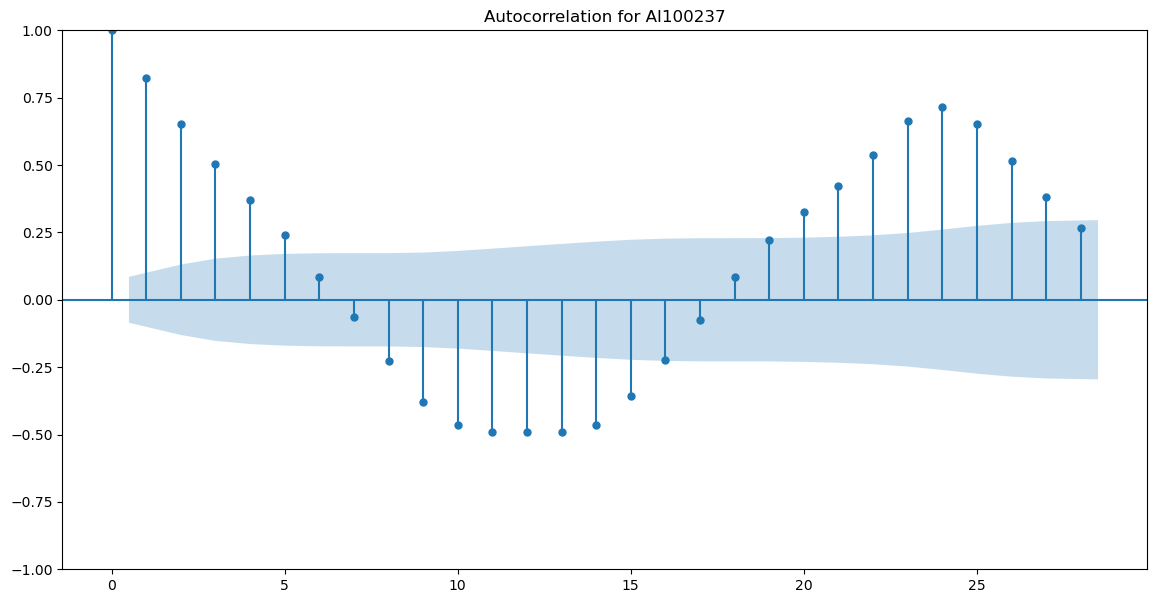

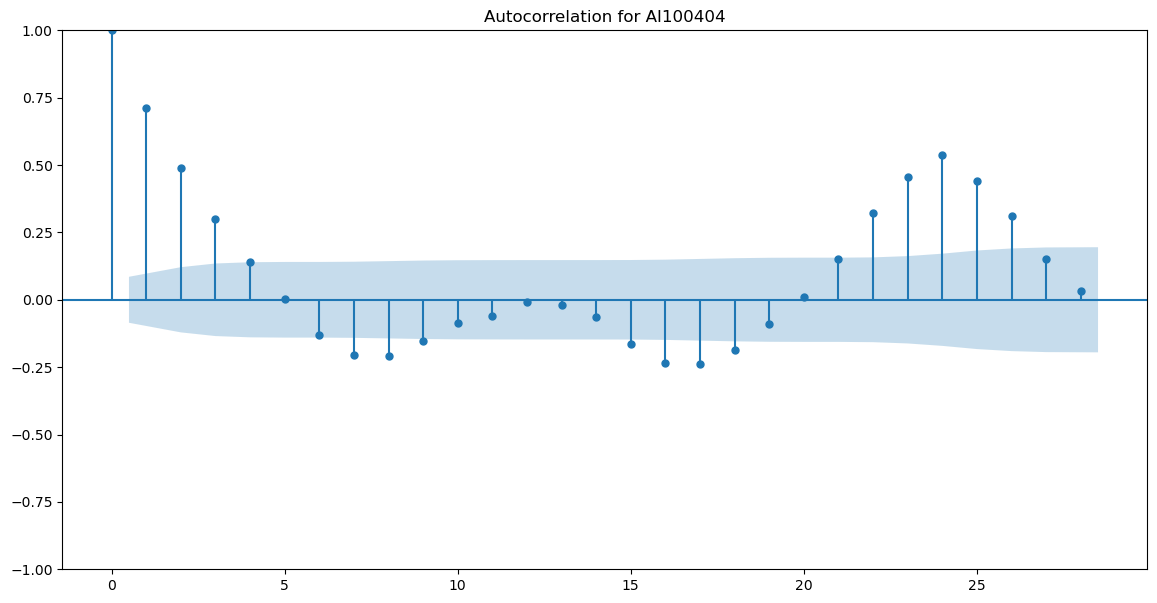

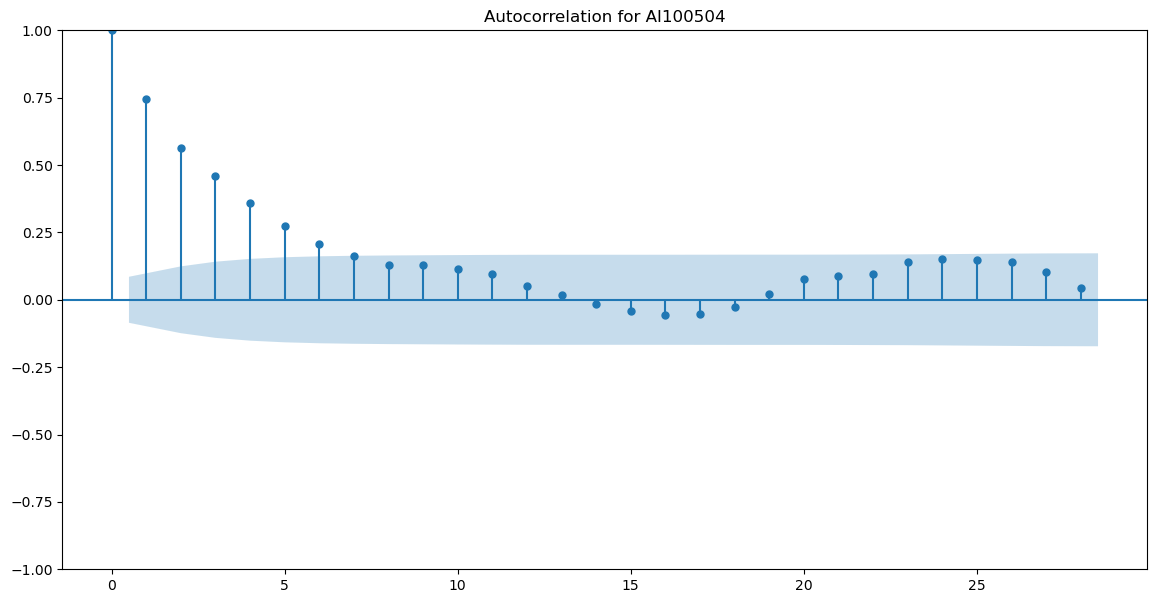

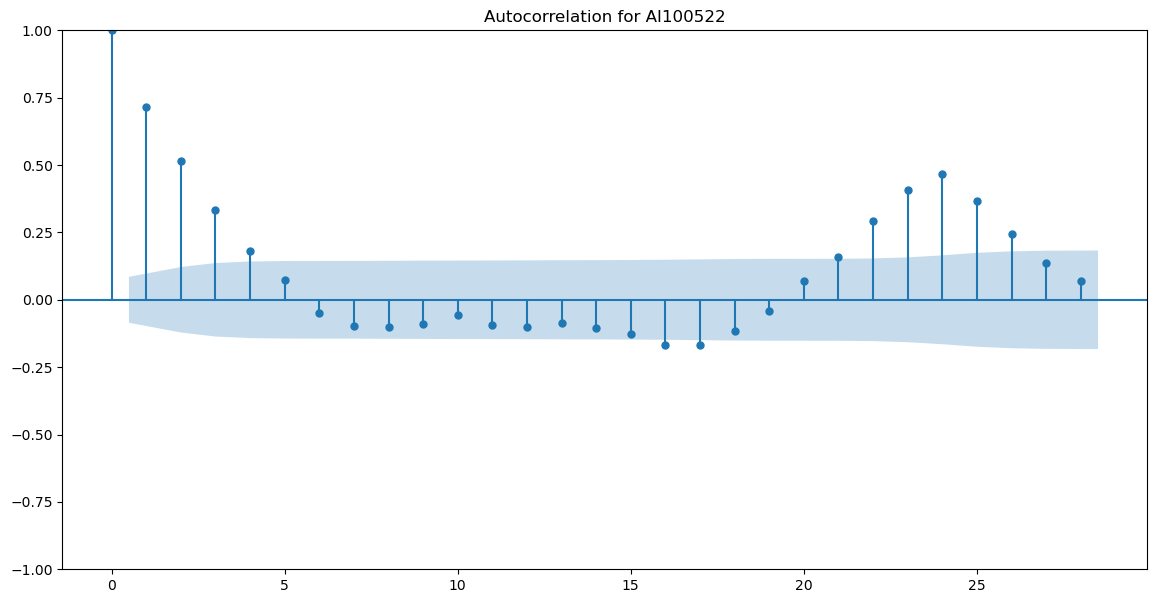

In [134]:
#Using autocorellation for selected machines it will be easier to find pattern or seasonality in the data
machine_names = df_train['machine_name'].unique()

for machine in machine_names[0:5]:
    selected_machine = df_train[df_train['machine_name'] == machine]
    if selected_machine.empty:
        continue
    plt.figure(figsize=(14,7))
    plot_acf(selected_machine['total'].dropna(), ax=plt.gca(), title=f'Autocorrelation for {machine}')
    plt.show()

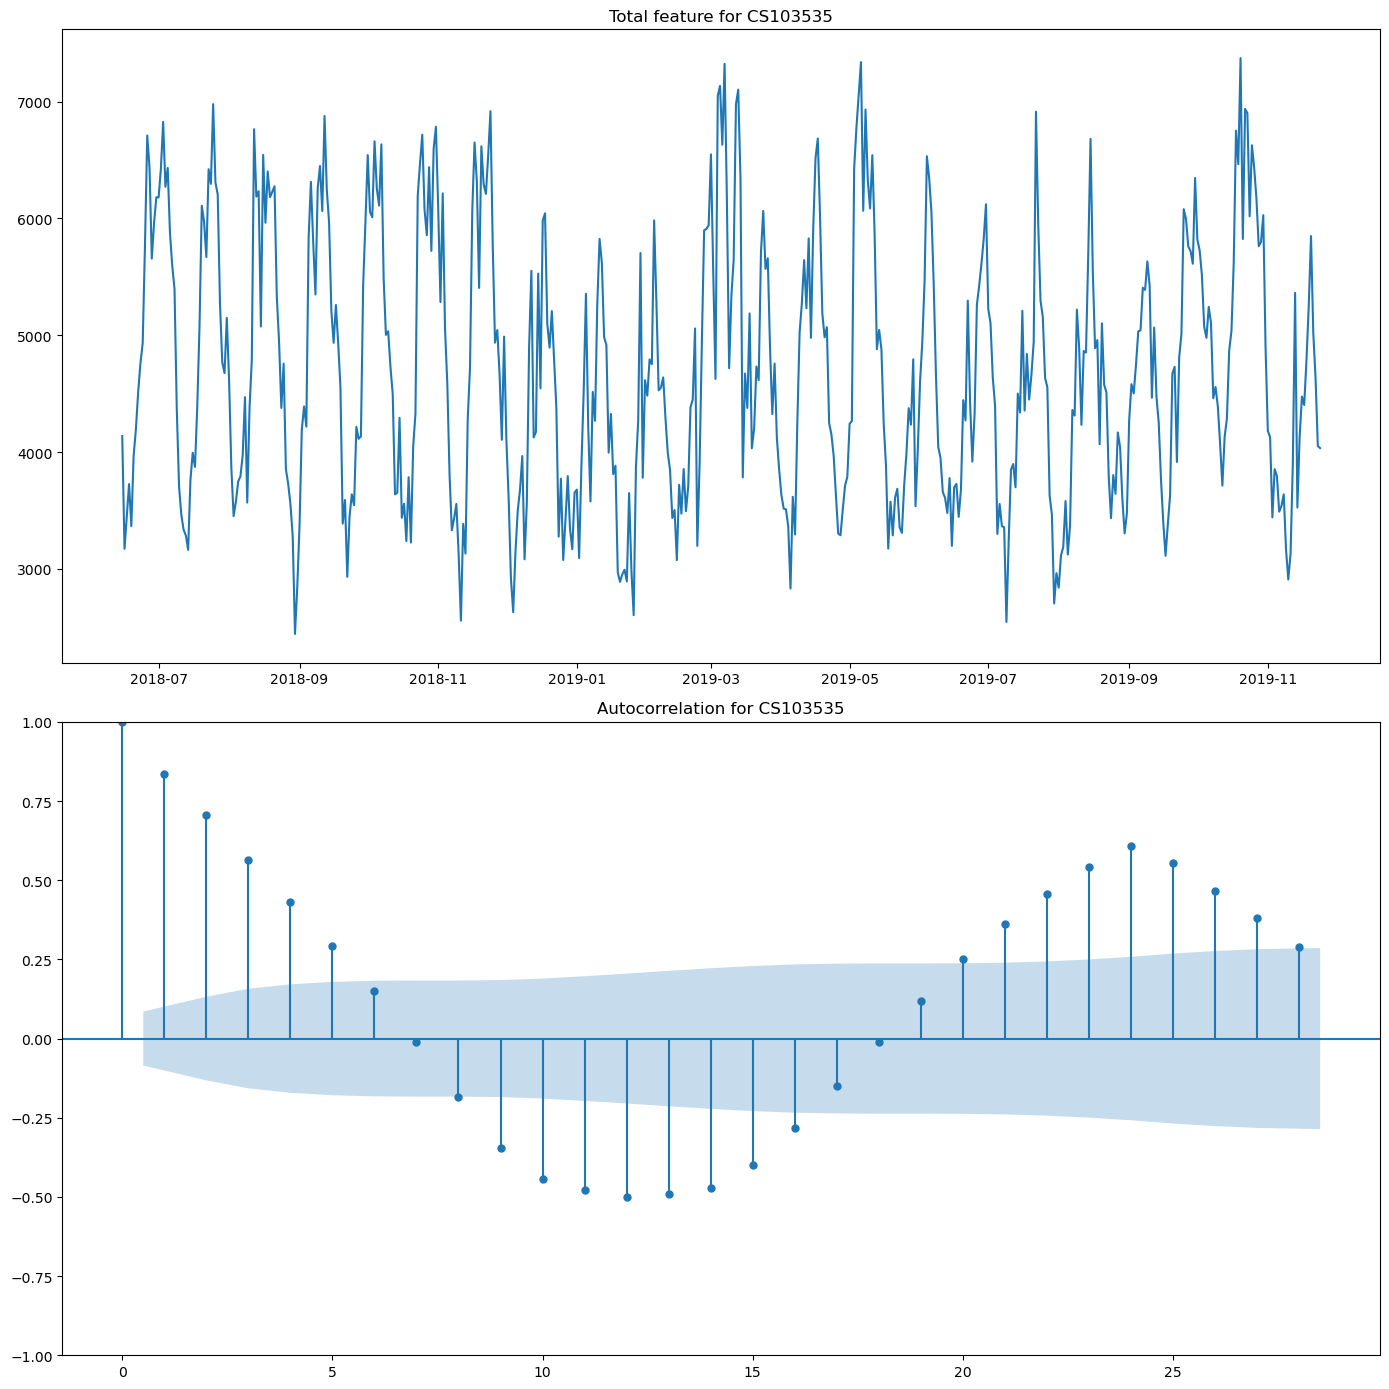

In [135]:
#manually from looking at the graphs I selected a machine that has a sensonality
selected_machine = df_train[df_train['machine_name'] == 'CS103535']
fig, ax = plt.subplots(2, 1, figsize=(14, 14))
ax[0].plot(selected_machine['timestamp'], selected_machine['total'])
ax[0].set_title('Total feature for CS103535')

plot_acf(selected_machine['total'].dropna(), ax=ax[1], title=f'Autocorrelation for CS103535')

plt.tight_layout()
plt.show()

As you can see this machine has seasonality  because in a time series is a repeating pattern observed within each period.

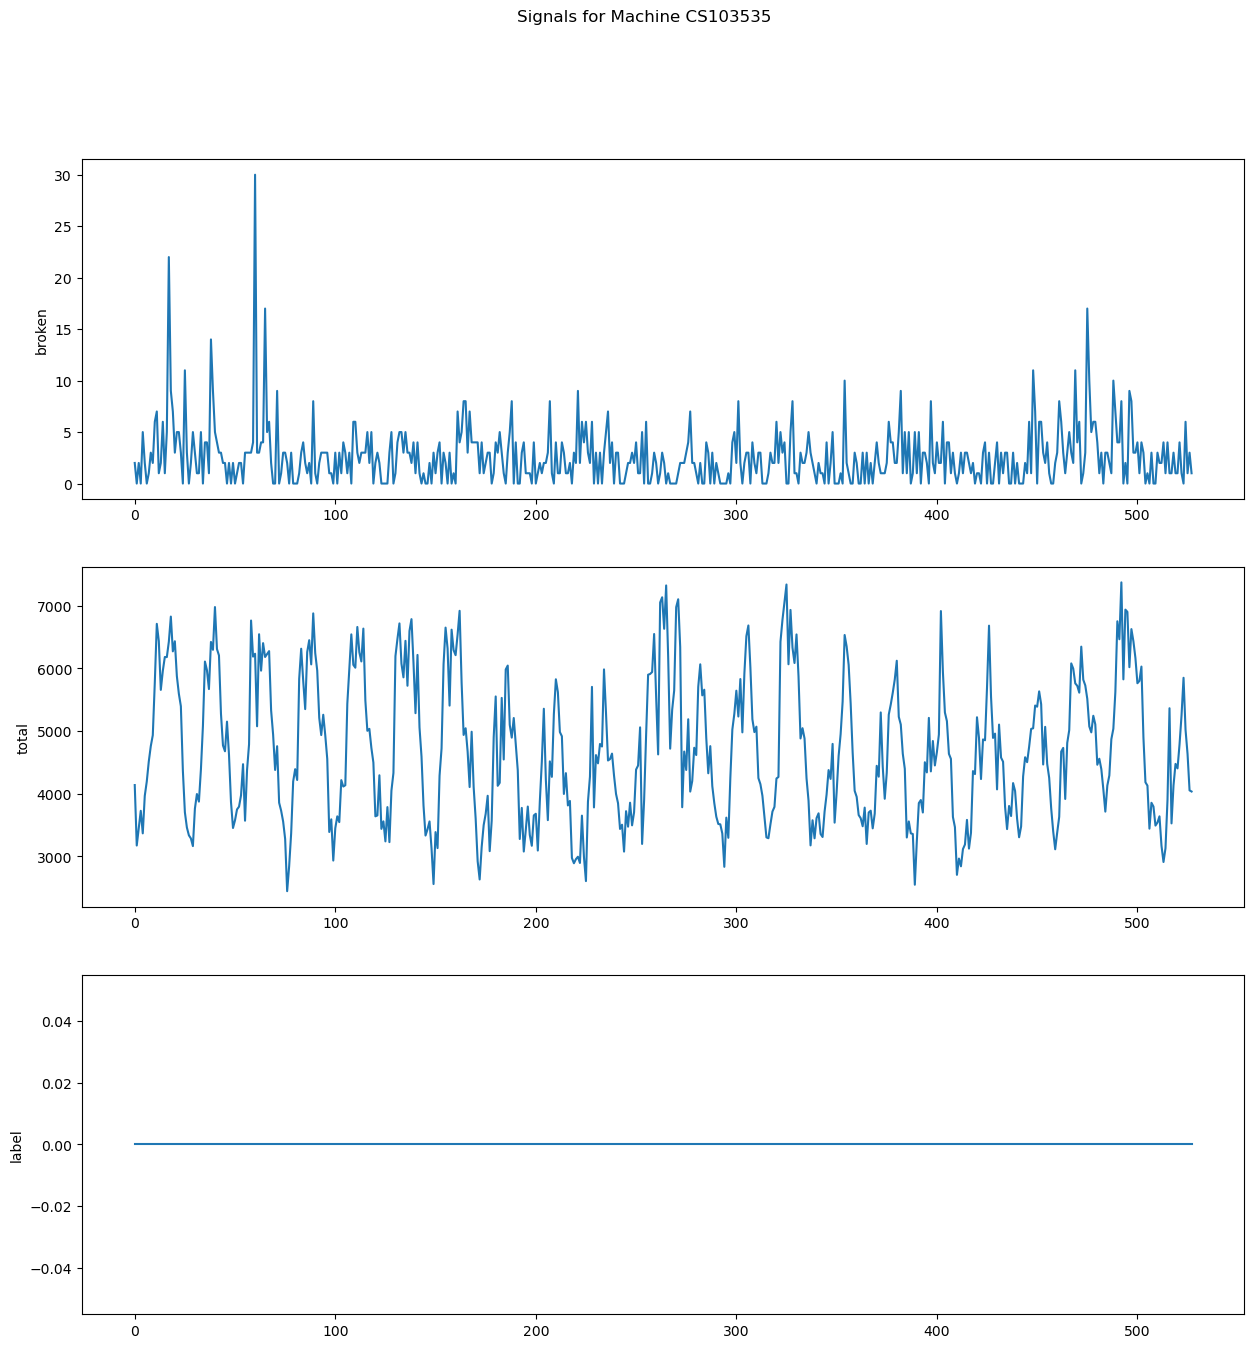

In [136]:
#Using a function from first exercise
plot_machine_signals(df_train,'CS103535')


2. Exponential smoothing
    Use 70% of the samples as a training set and the rest as a test set. Apply the exponential smoothing method (from statsmodels.tsa.holtwinters import ExponentialSmoothing) on the training set and forecast test set. Calculate the root mean square error and the mean absolute error of your prediction.
    Display a line graph showing the training set, the test set, and the predicted values of the exponential smoothing model. Do you find obtained predictions useful? Why?
    Try some form of parameter optimization to get a more accurate model. Do you manage to improve the model? Show a table of the parameters used and the errors obtained using these parameters.



In [137]:
df = temp_X_train.copy()
df['timedelta'] = pd.to_timedelta(df['day'], unit='D')
initial_timestamp = pd.Timestamp('2018-06-15 00:00:00')
df['timestamp'] = initial_timestamp + df['timedelta']
df.head()

,day,broken,total,label,machine_name,daily_broken_rate,broken_rate,broken_variance,daily_broken_rate_variance,broken_mean,...,daily_broken_rate_expanding_mean,broken_rate_expanding_mean,broken_mean_15,daily_broken_rate_mean_15,broken_std_15,daily_broken_rate_skew_15,broken_kurtosis_15,daily_broken_rate_kurtosis_15,timedelta,timestamp
0,0,0,1273,0,AI100196,0.00,0.000000,0.0,0.0,0.0,...,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0 days,2018-06-15
1,1,2,1218,0,AI100196,2.00,0.001642,0.0,0.0,0.0,...,2.0000,0.000821,0.0,0.0,0.0,0.0,0.0,0.0,1 days,2018-06-16
2,2,2,717,0,AI100196,1.00,0.002789,0.0,0.0,0.0,...,1.5000,0.001477,0.0,0.0,0.0,0.0,0.0,0.0,2 days,2018-06-17
3,3,0,399,0,AI100196,0.00,0.000000,0.0,0.0,0.0,...,1.0000,0.001108,0.0,0.0,0.0,0.0,0.0,0.0,3 days,2018-06-18
4,4,3,436,0,AI100196,0.75,0.006881,1.8,0.0,1.4,...,0.9375,0.002262,0.0,0.0,0.0,0.0,0.0,0.0,4 days,2018-06-19


In [138]:
X = df.copy()
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

In [139]:
X_train['total'].head()

0    1273
1    1218
2     717
3     399
4     436
Name: total, dtype: int64

In [140]:
X_train_transformed = X_train['total'] + 0.01

In [141]:
model = ExponentialSmoothing(X_train_transformed,seasonal_periods=20,trend=None, seasonal='add')
model_fit = model.fit()
pred = model_fit.forecast(len(X_test))
rmse = np.sqrt(mean_squared_error(X_test['total'], pred))
mae = mean_absolute_error(X_test['total'], pred)

print(f'RMSE: {rmse}, MAE: {mae}')

C:\Users\polet\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


RMSE: 2690.0317989097125, MAE: 1734.5893730705816


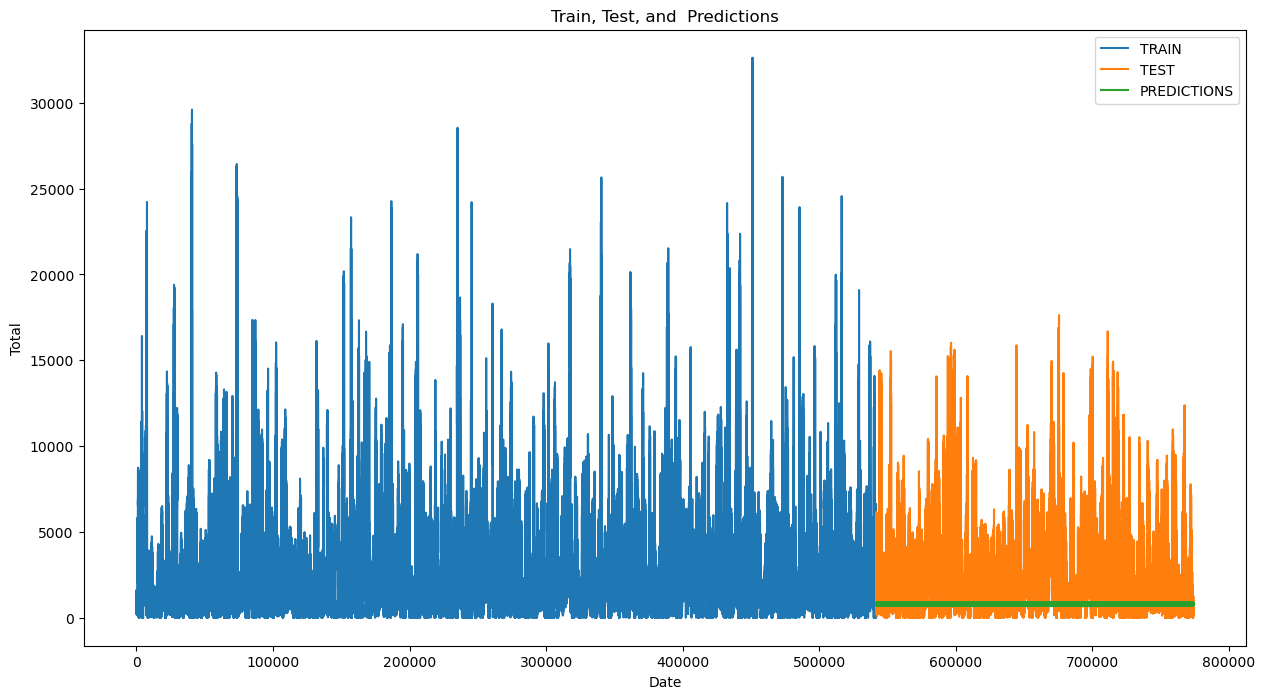

In [142]:
test_predictions_series = pd.Series(pred, index=X_test.index)

X_train['total'].plot(legend=True, label='TRAIN', figsize=(15, 8))
X_test['total'].plot(legend=True, label='TEST', figsize=(15, 8))
test_predictions_series.plot(legend=True, label='PREDICTIONS', figsize=(15, 8))

plt.title('Train, Test, and  Predictions')
plt.xlabel("Date")
plt.ylabel("Total")
plt.show()

In [143]:
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error

# Define the parameter values to try
seasonal_periods_values = [10, 20, 30]  # Example values for seasonal_periods
seasonal_values = ['add', 'mul']  # Example values for seasonal

# Initialize lists to store the results
results_rmse = []
results_mae = []

# Iterate over the parameter values
for seasonal_periods in seasonal_periods_values:
    for seasonal in seasonal_values:
        # Configure and fit the model
        model = ExponentialSmoothing(X_train_transformed, seasonal_periods=seasonal_periods, trend=None, seasonal=seasonal)
        model_fit = model.fit()

        # Make predictions
        pred = model_fit.forecast(len(X_test))

        # Calculate evaluation metrics
        rmse = np.sqrt(mean_squared_error(X_test['total'], pred))
        mae = mean_absolute_error(X_test['total'], pred)

        # Store the results
        results_rmse.append((seasonal_periods, seasonal, rmse))
        results_mae.append((seasonal_periods, seasonal, mae))

# Print the results
for result in results_rmse:
    print(f"Seasonal Periods: {result[0]}, Seasonal: {result[1]}, RMSE: {result[2]}")

for result in results_mae:
    print(f"Seasonal Periods: {result[0]}, Seasonal: {result[1]}, MAE: {result[2]}")


C:\Users\polet\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\polet\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\polet\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\polet\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\polet\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\polet\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

Seasonal Periods: 10, Seasonal: add, RMSE: 2676.747661454085
Seasonal Periods: 10, Seasonal: mul, RMSE: 3438.549068124938
Seasonal Periods: 20, Seasonal: add, RMSE: 2690.0317989097125
Seasonal Periods: 20, Seasonal: mul, RMSE: 3601.259995841586
Seasonal Periods: 30, Seasonal: add, RMSE: 2681.8275421887643
Seasonal Periods: 30, Seasonal: mul, RMSE: 2931.5362729351987
Seasonal Periods: 10, Seasonal: add, MAE: 1723.8271661770868
Seasonal Periods: 10, Seasonal: mul, MAE: 2609.8554307607583
Seasonal Periods: 20, Seasonal: add, MAE: 1734.5893730705816
Seasonal Periods: 20, Seasonal: mul, MAE: 2470.3854684507196
Seasonal Periods: 30, Seasonal: add, MAE: 1727.7133800937443
Seasonal Periods: 30, Seasonal: mul, MAE: 1985.0423455032844


3. ARIMA
    Use 70% of the samples as a training set and the rest as a test set. Apply the ARIMA model (from statsmodels.tsa.arima.model import ARIMA) with predefined parameters (0,0,0) and predict the values of the test set. Calculate the root mean square error and the mean absolute error of your prediction. Display a line graph showing the training set, the test set, and the predicted values of the ARIMA model along with the prediction confidence interval. What does the width of the confidence interval suggest? Do you find obtained prediction useful? Why?


In [144]:
X_train_transformed.head()

0    1273.01
1    1218.01
2     717.01
3     399.01
4     436.01
Name: total, dtype: float64

In [145]:
model = ARIMA(X_train_transformed, order=(0,0,0)) # p, d, q
model_fit = model.fit()

print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                  total   No. Observations:               541689
Model:                          ARIMA   Log Likelihood            -8321058.919
Date:                Wed, 24 May 2023   AIC                       16642121.839
Time:                        21:59:05   BIC                       16642144.244
Sample:                             0   HQIC                      16642128.160
                             - 541689                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2456.4185   1.87e+06      0.001      0.999   -3.67e+06    3.67e+06
sigma2      3.503e+12   9.52e+09    367.997      0.000    3.48e+12    3.52e+12
Ljung-Box (L1) (Q):              507686.13   Jarque-

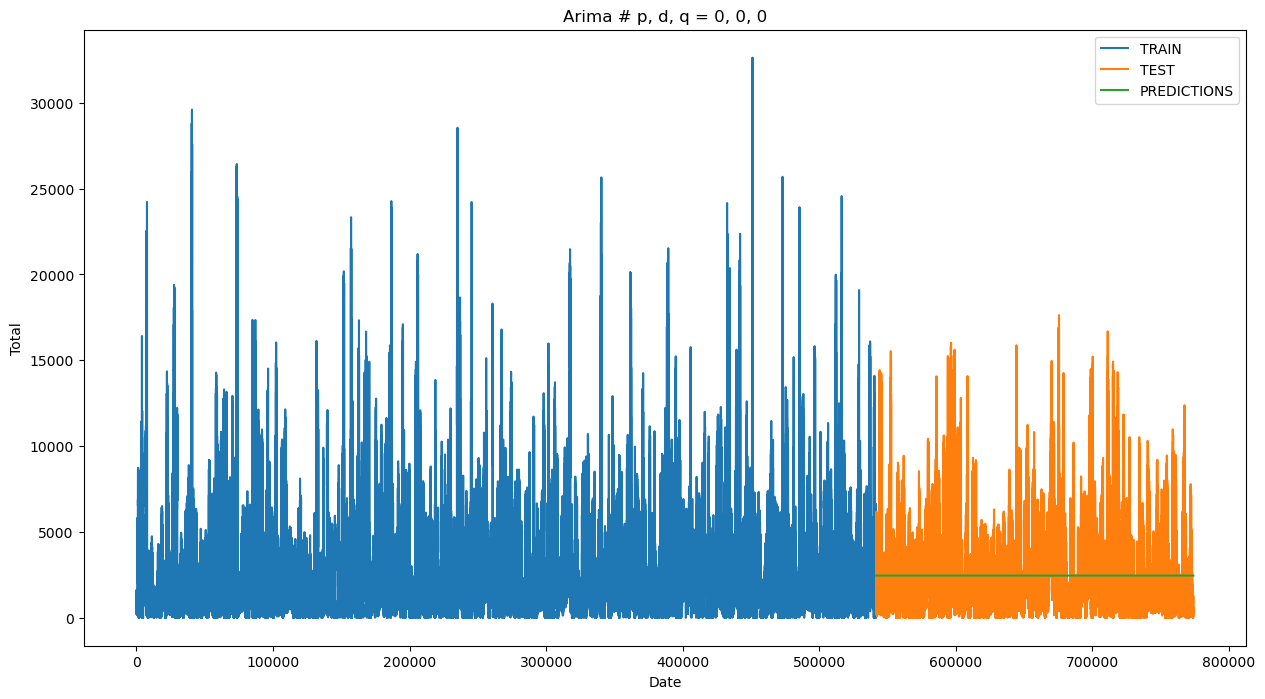

RMSE: 2244.9030292606794, MAE: 1701.8645639988372


In [146]:
predicted = model_fit.forecast(len(X_test))
test_predictions_series = pd.Series(predicted, index=X_test.index)

X_train['total'].plot(legend=True, label='TRAIN', figsize=(15, 8))
X_test['total'].plot(legend=True, label='TEST', figsize=(15, 8))
test_predictions_series.plot(legend=True, label='PREDICTIONS', figsize=(15, 8))

plt.title('Arima # p, d, q = 0, 0, 0')
plt.xlabel("Date")
plt.ylabel("Total")
plt.show()

rmse = np.sqrt(mean_squared_error(X_test['total'], predicted))
mae = mean_absolute_error(X_test['total'], predicted)

print(f'RMSE: {rmse}, MAE: {mae}')


In [147]:
def funARIMA(p, d, q, X_train, X_test, X_train_transformed):
    model = ARIMA(X_train_transformed, order=(p, d, q))
    model_fit = model.fit()

    print(model_fit.summary())

    forecast = model_fit.get_forecast(steps=len(X_test))
    predicted_mean = forecast.predicted_mean
    confidence_interval = forecast.conf_int()

    test_predictions_series = pd.Series(predicted_mean, index=X_test.index)

    X_train['total'].plot(legend=True, label='TRAIN', figsize=(15, 8))
    X_test['total'].plot(legend=True, label='TEST', figsize=(15, 8))
    test_predictions_series.plot(legend=True, label='PREDICTIONS', figsize=(15, 8))

    plt.fill_between(
        confidence_interval.index,
        confidence_interval.iloc[:, 0],
        confidence_interval.iloc[:, 1],
        color='gray',
        alpha=0.3
    )

    plt.title('ARIMA (p, d, q) = ({}, {}, {})'.format(p, d, q))
    plt.xlabel("Date")
    plt.ylabel("Total")
    plt.show()

    rmse = np.sqrt(mean_squared_error(X_test['total'], predicted_mean))
    mae = mean_absolute_error(X_test['total'], predicted_mean)

    print(f'RMSE: {rmse}, MAE: {mae}')


a)
    Try a few different values of the p parameter and leave the other parameters at 0. Can you reduce the error? Display a line prediction graph with the least error. How does the parameter p affect the appearance of the prediction?


                               SARIMAX Results                                
Dep. Variable:                  total   No. Observations:               541689
Model:                 ARIMA(4, 0, 0)   Log Likelihood            -4260433.585
Date:                Wed, 24 May 2023   AIC                        8520879.169
Time:                        21:59:54   BIC                        8520946.384
Sample:                             0   HQIC                       8520898.134
                             - 541689                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2456.4185     27.789     88.395      0.000    2401.953    2510.884
ar.L1          1.0710      0.000   2874.354      0.000       1.070       1.072
ar.L2         -0.0392      0.001    -62.205      0.0

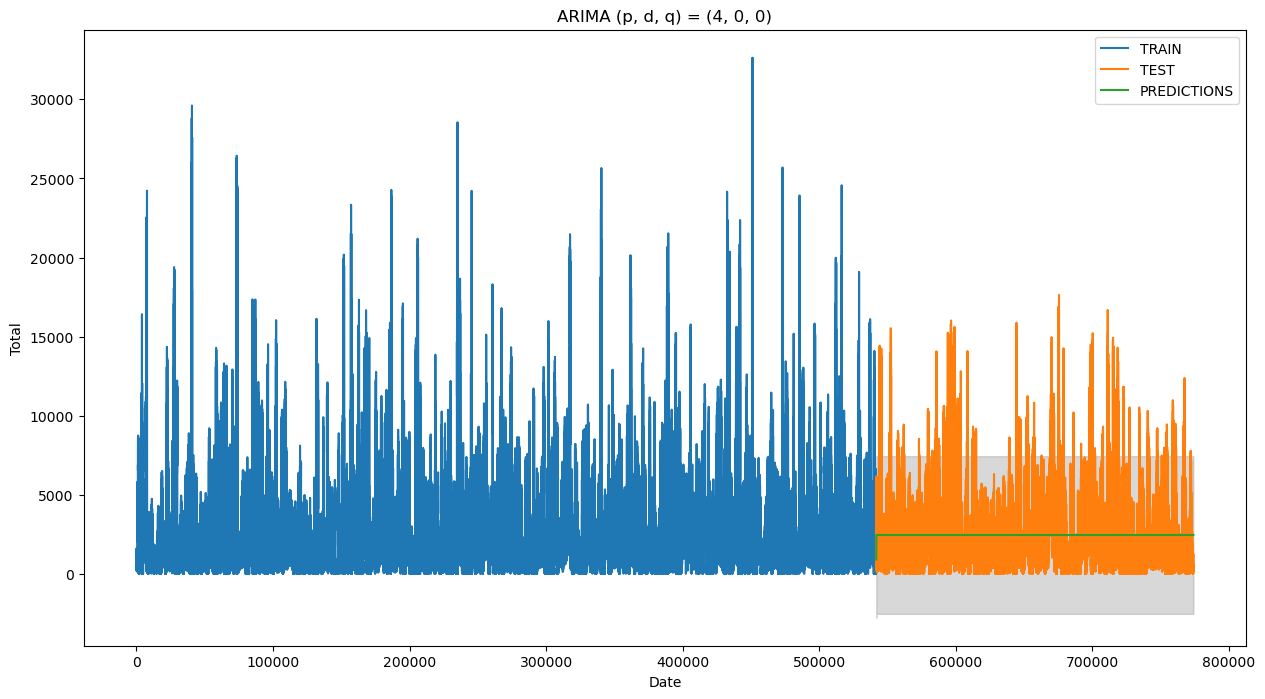

RMSE: 2244.857129387864, MAE: 1701.7462865537213


In [148]:
funARIMA(4,0,0,X_train,X_test,X_train_transformed)

b)
    Try a few different values of the q parameter and leave the other parameters at 0. Can you reduce the error? Display a line prediction graph with the least error. How does the q parameter affect the appearance of the prediction?

                               SARIMAX Results                                
Dep. Variable:                  total   No. Observations:               541689
Model:                 ARIMA(0, 3, 0)   Log Likelihood            -4723295.599
Date:                Wed, 24 May 2023   AIC                        9446593.198
Time:                        22:00:23   BIC                        9446604.400
Sample:                             0   HQIC                       9446596.358
                             - 541689                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.194e+06   1071.870   2047.133      0.000    2.19e+06     2.2e+06
Ljung-Box (L1) (Q):              236556.67   Jarque-Bera (JB):          18911188.31
Prob(Q):                              0.00   Pr

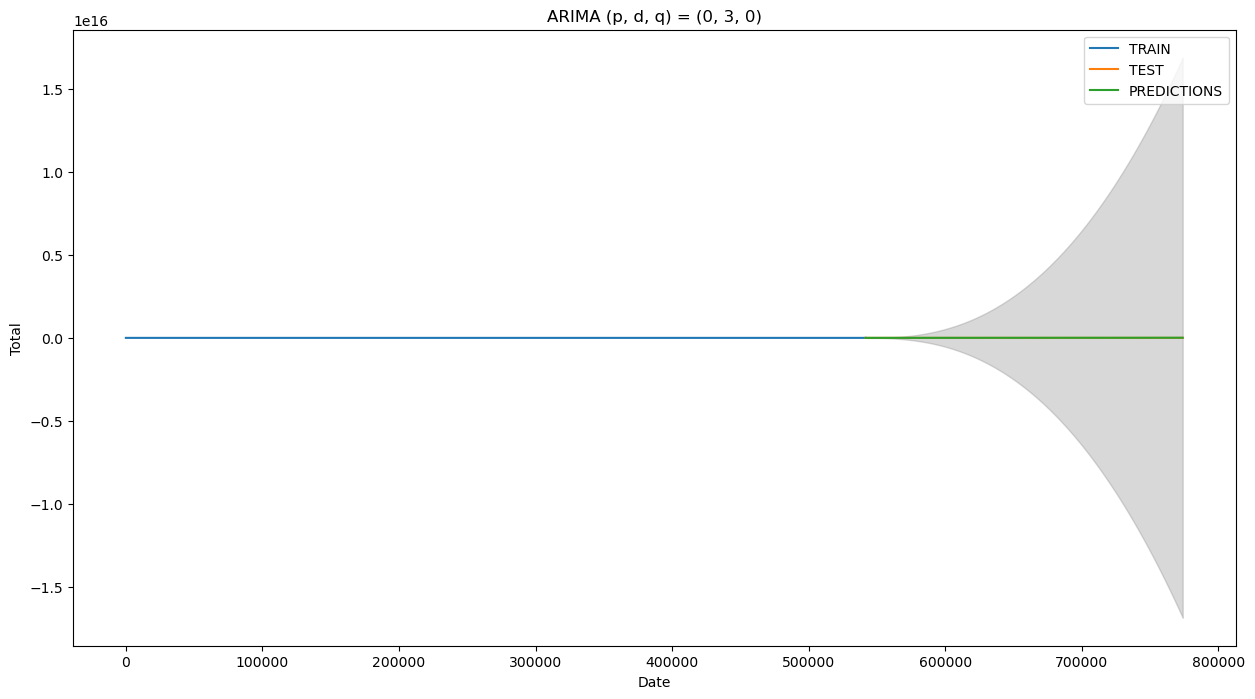

RMSE: 4109543715210.27, MAE: 3063080965818.32


In [149]:
funARIMA(0,3,0,X_train,X_test,X_train_transformed)


c)
    Try a few different values of parameter d and leave the other parameters at 0. Can you reduce the error? Display a line prediction graph with the least error. How does parameter d affect the appearance of the prediction?

C:\Users\polet\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                  total   No. Observations:               541689
Model:                 ARIMA(0, 0, 5)   Log Likelihood            -4363356.062
Date:                Wed, 24 May 2023   AIC                        8726726.125
Time:                        22:06:15   BIC                        8726804.542
Sample:                             0   HQIC                       8726748.251
                             - 541689                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2456.4189      6.825    359.916      0.000    2443.042    2469.796
ma.L1          1.2268      0.000   2753.277      0.000       1.226       1.228
ma.L2          1.2405      0.001   1885.641      0.0

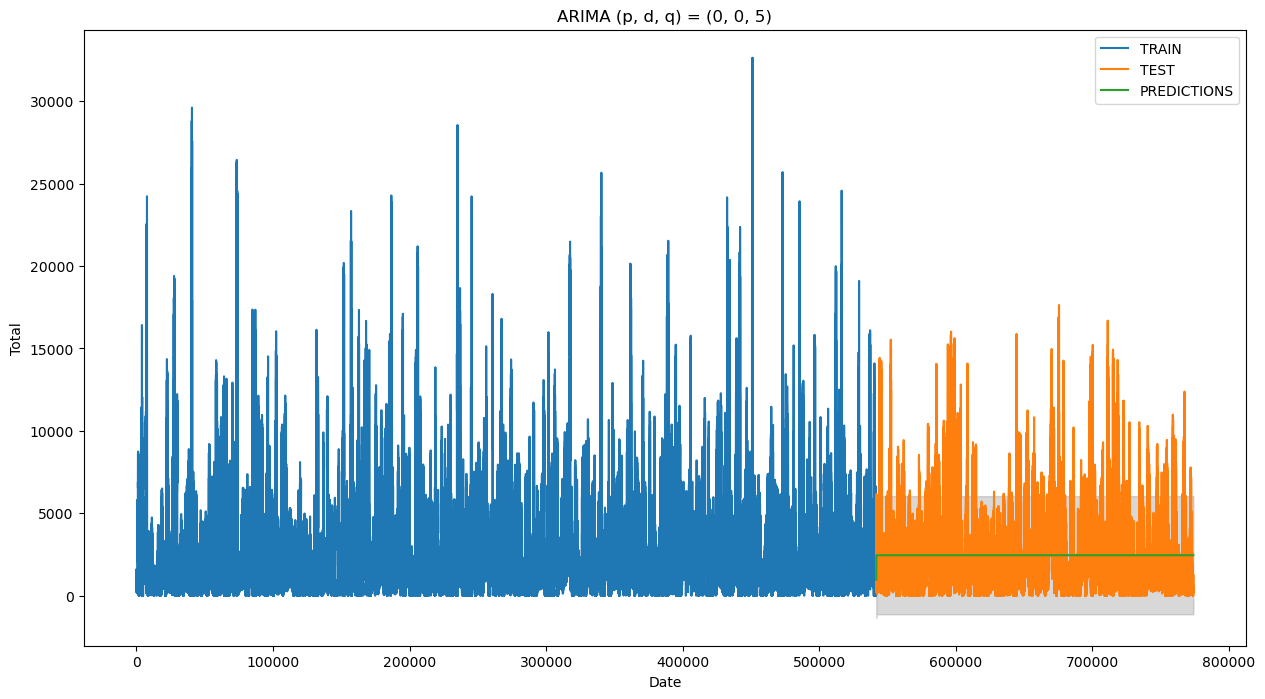

RMSE: 2244.8948537594024, MAE: 1701.8484483638053


In [150]:
funARIMA(0,0,5,X_train,X_test,X_train_transformed)


e)
    Try changing the parameter s (seasonality). Do you manage to reduce the error? Display a line prediction graph with the least error. How does the s parameter affect the appearance of the prediction?
    Show a table of the parameters used and the errors obtained using these parameters.

                               SARIMAX Results                                
Dep. Variable:                  total   No. Observations:               541689
Model:                 ARIMA(0, 3, 0)   Log Likelihood            -4723295.599
Date:                Wed, 24 May 2023   AIC                        9446593.198
Time:                        22:06:43   BIC                        9446604.400
Sample:                             0   HQIC                       9446596.358
                             - 541689                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.194e+06   1071.870   2047.133      0.000    2.19e+06     2.2e+06
Ljung-Box (L1) (Q):              236556.67   Jarque-Bera (JB):          18911188.31
Prob(Q):                              0.00   Pr

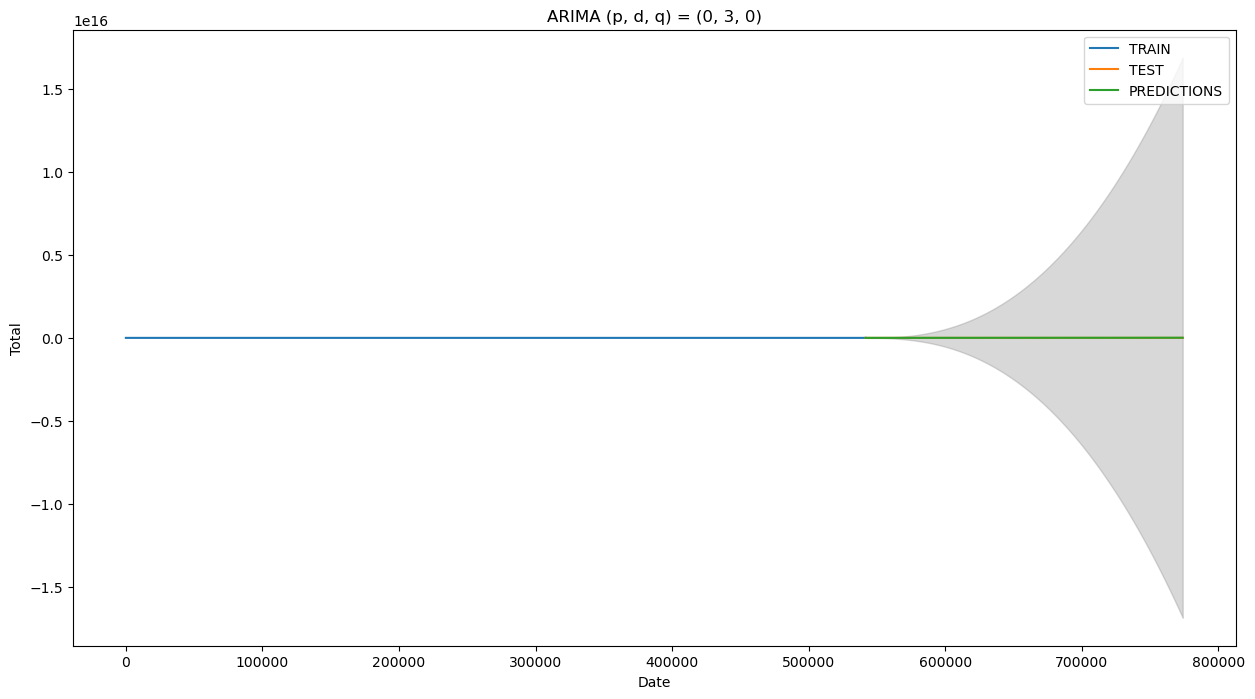

RMSE: 4109543715210.27, MAE: 3063080965818.32


In [151]:
funARIMA(0,3,0,X_train,X_test,X_train_transformed)


d)
    Perform the optimization of the parameters p, d and q at the same time and try to reduce the error. Do you manage to significantly improve the model? Display a line graph of the prediction with the least error.

In [152]:

def calculate_errors(actual, predicted):
    predicted_mean = predicted.predicted_mean
    rmse = np.sqrt(mean_squared_error(actual, predicted_mean))
    mae = mean_absolute_error(actual, predicted_mean)
    return rmse, mae

# Generate combinations of p, d, q parameters
p_values = [0, 1, 2]
d_values = [0, 1]
q_values = [0, 1, 2]

results = []

# Iterate over parameter combinations
for p, d, q in itertools.product(p_values, d_values, q_values):
    # Fit ARIMA model
    model = ARIMA(X_train_transformed, order=(p, d, q))
    model_fit = model.fit()

    predicted = model_fit.get_forecast(steps=len(X_test), alpha=0.05)
    test_predictions_series = pd.Series(predicted.predicted_mean, index=X_test.index)

    rmse, mae = calculate_errors(X_test['total'], predicted)

    results.append({
        'p': p,
        'd': d,
        'q': q,
        'RMSE': rmse,
        'MAE': mae
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Find parameters with minimum RMSE
min_rmse_idx = results_df['RMSE'].idxmin()
best_params = results_df.loc[min_rmse_idx, ['p', 'd', 'q']]
best_rmse = results_df.loc[min_rmse_idx, 'RMSE']
best_mae = results_df.loc[min_rmse_idx, 'MAE']

print(f'Best parameters: {best_params.values}')
print(f'Best RMSE: {best_rmse}')
print(f'Best MAE: {best_mae}')
print(results_df.loc[min_rmse_idx, ['p', 'd', 'q']])
print(results_df)


C:\Users\polet\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\polet\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\polet\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\polet\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Best parameters: [1. 0. 0.]
Best RMSE: 2244.8314599878413
Best MAE: 1701.6832900931918
p    1.0
d    0.0
q    0.0
Name: 6, dtype: float64
    p  d  q         RMSE          MAE
0   0  0  0  2244.903029  1701.864564
1   0  0  1  2244.901460  1701.861236
2   0  0  2  2244.901073  1701.860519
3   0  1  0  2661.604339  1712.138185
4   0  1  1  2656.920420  1708.633991
5   0  1  2  2663.485108  1713.554117
6   1  0  0  2244.831460  1701.683290
7   1  0  1  2244.842567  1701.711619
8   1  0  2  2244.848806  1701.726756
9   1  1  0  2657.415878  1709.003448
10  1  1  1  2664.346349  1714.204017
11  1  1  2  2665.398666  1714.999547
12  2  0  0  2244.845579  1701.719051
13  2  0  1  2244.858854  1701.750252
14  2  0  2  2244.859132  1701.750889
15  2  1  0  2664.349984  1714.206777
16  2  1  1  2665.423166  1715.018097
17  2  1  2  2665.332871  1714.949801


4. Facebook Prophet
    Prophet (from fbprophet import Prophet) requires as the input set a DataFrame with columns ds and y. y is the value of our time series, and ds is a DateTime column with the moment of that event. Since we do not have information on the exact time, we will assume that the first sample was at timestamp 2018-06-15 00 : 00 : 00, and each subsequent sample was played 24H after the previous one.
    Train the Prophet algorithm on the first 70% of samples and make predictions for the rest of the signal. Using the built-in functions within the fbprophet library, draw a prediction graph and graphs of the individual predictive components of the Prophet algorithm. Calculate the root mean square error and the mean absolute error.
    Manually set the seasonalities observed in the signal (if any) and change their Fourier order parameter values. Do you manage to reduce the error? What prediction does the Prophet algorithm give compared to previously tested algorithms?
    Show a table of the parameters used and the errors obtained using these parameters.



In [153]:
df['timedelta'] = pd.to_timedelta(df['day'], unit='D')
initial_timestamp = pd.Timestamp('2018-06-15 00:00:00')
df['timestamp'] = initial_timestamp + df['timedelta']
df.head()

,day,broken,total,label,machine_name,daily_broken_rate,broken_rate,broken_variance,daily_broken_rate_variance,broken_mean,...,daily_broken_rate_expanding_mean,broken_rate_expanding_mean,broken_mean_15,daily_broken_rate_mean_15,broken_std_15,daily_broken_rate_skew_15,broken_kurtosis_15,daily_broken_rate_kurtosis_15,timedelta,timestamp
0,0,0,1273,0,AI100196,0.00,0.000000,0.0,0.0,0.0,...,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0 days,2018-06-15
1,1,2,1218,0,AI100196,2.00,0.001642,0.0,0.0,0.0,...,2.0000,0.000821,0.0,0.0,0.0,0.0,0.0,0.0,1 days,2018-06-16
2,2,2,717,0,AI100196,1.00,0.002789,0.0,0.0,0.0,...,1.5000,0.001477,0.0,0.0,0.0,0.0,0.0,0.0,2 days,2018-06-17
3,3,0,399,0,AI100196,0.00,0.000000,0.0,0.0,0.0,...,1.0000,0.001108,0.0,0.0,0.0,0.0,0.0,0.0,3 days,2018-06-18
4,4,3,436,0,AI100196,0.75,0.006881,1.8,0.0,1.4,...,0.9375,0.002262,0.0,0.0,0.0,0.0,0.0,0.0,4 days,2018-06-19


In [154]:
df = df.rename(columns={'timestamp': 'ds', 'total': 'y'})

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
C:\Users\polet\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\polet\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\polet\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


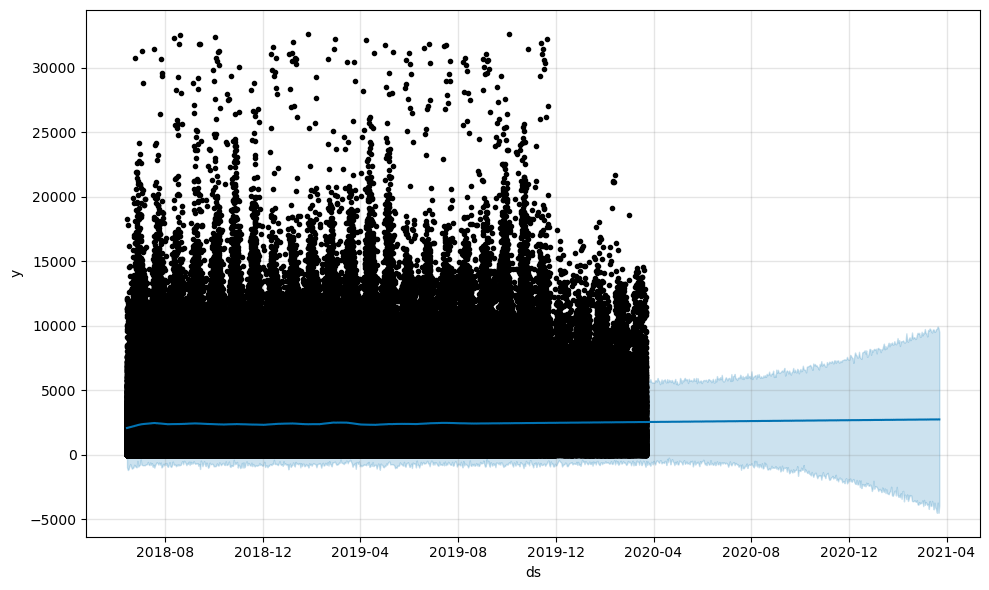

C:\Users\polet\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\polet\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


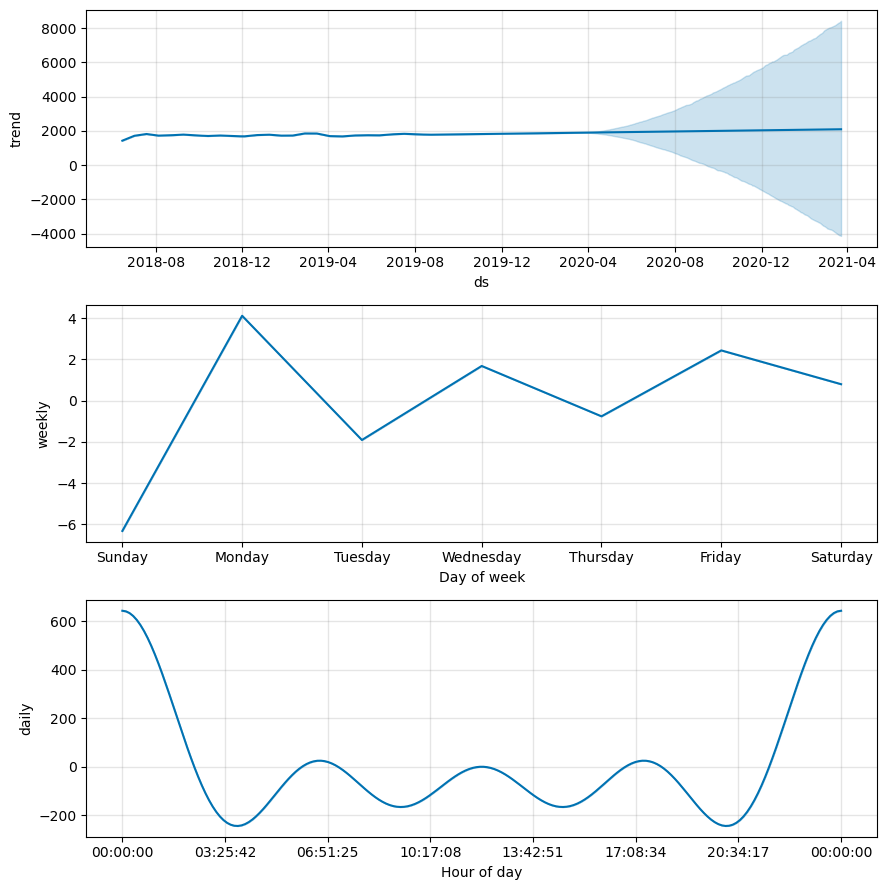

In [155]:
model_prophet = Prophet(daily_seasonality=True) # Enable daily seasonality for daily data, adjust as per the frequency of your data
model_prophet.fit(df[['ds', 'y']])

future = model_prophet.make_future_dataframe(periods=365) # Forecasting for 1 year from now.

forecast = model_prophet.predict(future)

# Plotting the forecast
model_prophet.plot(forecast)
plt.show()

# You can also view components of your forecast like trend and seasonality
model_prophet.plot_components(forecast)
plt.show()


C:\Users\polet\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\polet\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\polet\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


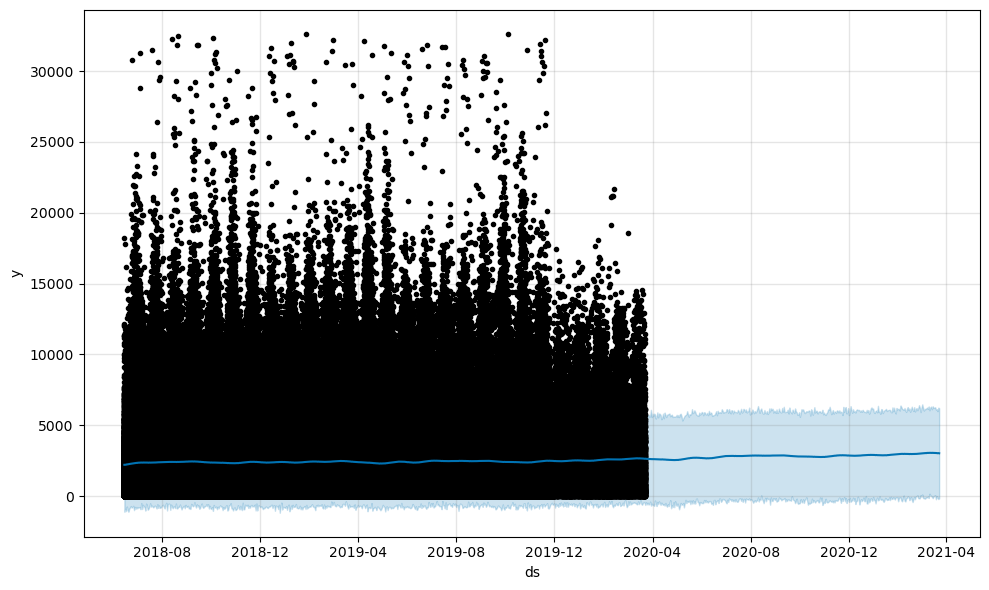

C:\Users\polet\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\polet\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\polet\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


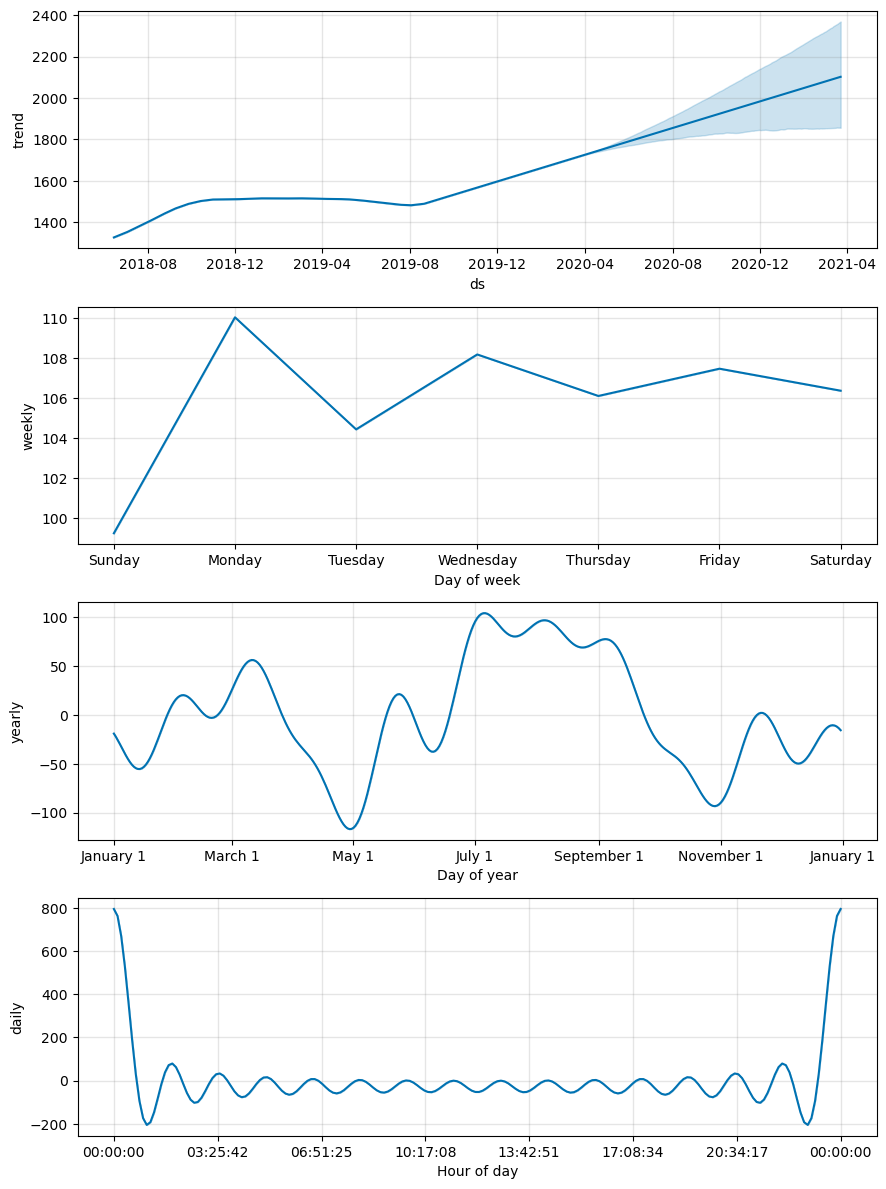

In [156]:
df = df.rename(columns={'timestamp': 'ds', 'total': 'y'})
model_prophet = Prophet(daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=False)
model_prophet.add_seasonality(name='daily', period=1, fourier_order=15)
model_prophet.add_seasonality(name='weekly', period=7, fourier_order=20)
model_prophet.add_seasonality(name='yearly', period=365.25, fourier_order=10)

model_prophet.fit(df[['ds', 'y']])

future = model_prophet.make_future_dataframe(periods=365)

forecast = model_prophet.predict(future)

# Plotting the forecast
model_prophet.plot(forecast)
plt.show()

# View components of your forecast
model_prophet.plot_components(forecast)
plt.show()


5. RandomForestRegressor
    Use RandomForestRegressor to predict the total number. Use all features for the regression model. We set aside the first 70% of samples as a training set, and we test the model on the rest of the signal. Using features from the current sample, we predict the value for the feature total in the next sample.
    Train RandomForestRegressor using a training set. Predict the value of the feature total for the test set. Calculate the root mean square error and the mean absolute error. Display a line graph showing the training set, the test set, and the predicted values of the regression model. What are the results compared to those obtained by previously tested algorithms?



In [157]:
X_test['total'].head()

541689    980
541690    625
541691    820
541692    501
541693    637
Name: total, dtype: int64

In [158]:
X_train = df.drop('machine_name', axis=1)
X_test = df.drop('machine_name', axis=1)

model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train.iloc[:, :3], X_test.iloc[:, :3])

# Make predictions
predictions = model_rf.predict(X_test.iloc[:, :3])

# Check the mean squared error
mse = mean_squared_error(X_test['total'], predictions[:,2])
print('Test MSE: %.3f' % mse)

# Plotting
plt.plot(X_test['total'], label='Actual')
plt.plot(predictions[:,2], label='Predicted')
plt.legend()
plt.show()

KeyError: 'total'

6.  Generated signal
    Use the code written below to generate a synthetic signal. Display the entire signal. What components does the generated signal consist of? Is there a signal periodicity? If yes, what is the period of periodicity and visualize the part of the signal where it can be seen. Is there a trend in the signal? If yes, what is it like?
    Repeat the assignments for exponential smoothing, ARIMA and Prophet using the signal generated this way.

In [ ]:
t = np.linspace(0, 600, 600)
triangle1 = signal.sawtooth(2 * np.pi * 2 * 200 * t)
triangle2 = signal.sawtooth(2 * np.pi * 2 * 28.57142857 * t, 0.63)
trend = np.linspace(0, 600, 600)/(134*np.pi)
trend1 = np.linspace(0, 100, 100)/(104*np.pi)
trend2 = np.linspace(0, 300, 300)/(-122*np.pi)
trend3 = np.linspace(0, 200, 200)/(111*np.pi/2)
noise = np.random.normal(0,0.1056,600)
pts = triangle1 + triangle2 + trend + np.concatenate((trend1, trend2, trend3)) + noise

# constants
last_n_rows = 600
n_train_rows = 500

# split
pts_train = pts[:-(last_n_rows-n_train_rows)]
pts_test = pts[-(last_n_rows-n_train_rows):]

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(t, pts)
plt.title('Synthetic Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()


As for the periodicity, it seems that there will be periodicity due to the triangle waves, and the periods can be inferred from the frequency of the waves which is the reciprocal of the frequency.
As for the trend in the signal, it appears to be piecewise linear. The trends change three times in the signal, creating different slopes at different time intervals.

In [ ]:
df = pd.DataFrame(pts, columns=['y'])
df['ds'] = pd.date_range(start='1/1/2020', periods=len(df), freq='D')
df = df[['ds', 'y']]


In [ ]:
train, test = df.iloc[:500, 1], df.iloc[500:, 1]
model = ExponentialSmoothing(train, seasonal='add', seasonal_periods=7)
model_fit = model.fit()

# Forecast
y_hat = model_fit.predict(start=len(train), end=len(train)+len(test)-1)

plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(y_hat.index, y_hat, label='Exponential Smoothing')
plt.legend(loc='best')
plt.show()


In [ ]:
model = ARIMA(train, order=(8,2,3))
model_fit = model.fit()
y_hat = model_fit.predict(start=len(train), end=len(train)+len(test)-1, typ='levels')

plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(y_hat.index, y_hat, label='ARIMA')
plt.legend(loc='best')
plt.show()


In [ ]:
# fit model
model_prophet = Prophet(daily_seasonality=True)
model_prophet.fit(df[:500])

# make future dataframe
future = model_prophet.make_future_dataframe(periods=100)

# make prediction
forecast = model_prophet.predict(future)

# plot
model_prophet.plot(forecast)
plt.show()

# check components
model_prophet.plot_components(forecast)
plt.show()
